In [91]:
import pandas as pd
import folium
import numpy as np
import json
import matplotlib.pyplot as plt

In [92]:
def save_map(map_name, filename):
    map_filename = "maps/"+filename+".html"
    map_name.save(map_filename)


In [93]:
# load the dataset of unemployment rate
unemployment_data = pd.read_excel('data/lfsq_urgan.xls')
unemployment_data.columns = np.append("Unemployment rates by citizenship (%)",unemployment_data.iloc[10][1:])

#We drop useless rows and match country names to the ones in the topojson file
unemployment_data = unemployment_data.drop(np.append(range(0,17),range(50,151)))
unemployment_data = unemployment_data.reset_index(drop=True)
unemployment_data['Unemployment rates by citizenship (%)'][4] = 'Germany'
unemployment_data['Unemployment rates by citizenship (%)'][31] = 'The former Yugoslav Republic of Macedonia'
unemployment_data.head()

,Unemployment rates by citizenship (%),2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2
0,Belgium,8.8,8.4,8.2,8.7,8.3,7.9,7.9,7.2,7.7,7
1,Bulgaria,10.6,9.9,8.3,7.9,8.6,8.1,7,6.7,6.9,6.3
2,Czech Republic,6,4.9,4.8,4.5,4.4,3.9,4,3.6,3.5,3
3,Denmark,6.6,6,6.2,5.8,6.3,6,6.3,6.1,6.5,5.5
4,Germany,5,4.7,4.4,4.5,4.5,4.2,4,3.8,4.1,3.8


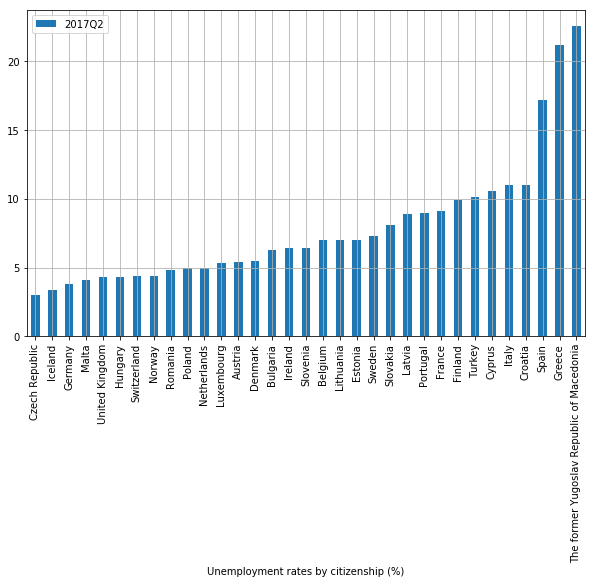

In [94]:
#We sort by employement rate for the second quarter of 2017 as it is the most recent data we have 
#for all EU countries and plot it.
unemployment_data = unemployment_data.sort_values('2017Q2')
plot01 = unemployment_data.plot(y='2017Q2', x=['Unemployment rates by citizenship (%)'], kind='bar', grid=True, figsize=(10, 6))
plt.show()


We can see that most values lie between 3% and 12% so we will create our scale so it is more precise (i. e. more interval classes) for these values.

In [95]:
#load topojson and create map with folium using the loaded data
topo_json_data = json.load(open(r'topojson/europe.topojson.json'))
m_eu = folium.Map([52,10], tiles='cartodbpositron', zoom_start=4)
a=folium.TopoJson(topo_json_data,'objects.europe')
a.add_to(m_eu)

In [96]:
from branca.colormap import linear

m_eu = folium.Map([52,10], tiles='cartodbpositron', zoom_start=4)

colormap = linear.GnBu.scale(
    unemployment_data['2017Q2'].min(),
    unemployment_data['2017Q2'].max())

#creation of interval classes
threshold_scale=[3, 6, 10, 12, 23]

#returns unemployment rate for a given country name if available
def printCountry(state):
    if(state in unemployment_data['Unemployment rates by citizenship (%)'].tolist()):
        return colormap(unemployment_data['2017Q2'][unemployment_data['Unemployment rates by citizenship (%)'].tolist().index(state)])
    else: print(state)

colormap

We choose the linear scale 'GnBu' which is a scale used to represent divergent data using light colors for weak unemployement rate and dark colors for high ones. White is used to represent missing data.

In [97]:
def decodeArc(arcs) :
    x=0;y=0
    conversion = []
    for arc in arcs:
        arc1 = (x + arc[0])*topo_json_data['transform']['scale'][0]+topo_json_data['transform']['translate'][0]
        arc2 = (y + arc[1])*topo_json_data['transform']['scale'][1]+topo_json_data['transform']['translate'][1]
        conversion.append([arc1,arc2])
        x += arc[0]
        y += arc[1]
    return conversion

In [98]:
def reconstruct_shape(arcIdx,shape):
    if(shape == 'MultiPolygon') :
        layer1=[]
        for x in range(len(arcs)):
            layer2 = []
            for y in range(len(arcs[x])):
                layer3 = []
                for z in range(len(arcs[x][y])):
                    if(arcs[x][y][z] <0):
                        layer3=layer3 + decodeArc(arcIndices[-arcs[x][y][z]-1])[::-1]
                    else:   
                        layer3=layer3 + decodeArc(arcIndices[arcs[x][y][z]])
                layer2.append(layer3)
            layer1.append(layer2)
        return layer1
    if(shape == 'Polygon') :
        layer1=[]
        for x in range(len(arcs)):
            layer2 = []
            for y in range(len(arcs[x])):
                if(arcs[x][y] <0):
                    layer2=layer2 + decodeArc(arcIndices[-arcs[x][y]-1])[::-1]
                else :   
                    layer2=layer2 + decodeArc(arcIndices[arcs[x][y]])
            layer1.append(layer2)
        return layer1  

In [99]:
m_eu = folium.Map([52,10], tiles='cartodbpositron', zoom_start=4)

m_eu.choropleth(geo_data=topo_json_data, data=unemployment_data,
                key_on='properties.NAME',
                threshold_scale=threshold_scale,
                columns=['Unemployment rates by citizenship (%)','2017Q2'],
                fill_color='GnBu', fill_opacity=.75, line_opacity=0.5,
                legend_name='Percentage of unemployment per country (%) (2nd quarter of 2017)',
                topojson='objects.europe')


arcIndices = topo_json_data['arcs']
for country in topo_json_data['objects']['europe']['geometries']:
    shape = country['type']
    arcs = country['arcs']
    gj = folium.GeoJson(
        data={
            'type': shape,
            'coordinates': reconstruct_shape(arcs,shape)
        }, style_function=  lambda x: {'fillColor': 'white',
                                       'opacity': 0,
                                       'color': 'white',
                                       'fillOpacity': 0}
    )
    try:
        gj.add_child(folium.Popup(country['properties']['NAME']+': '+repr(unemployment_data.set_index('Unemployment rates by citizenship (%)')['2017Q2'][country['properties']['NAME']])+'%'))
    except KeyError:
        gj.add_child(folium.Popup((country['properties']['NAME']+': unkown')))
    gj.add_to(m_eu)
    
save_map(m_eu,"task1")

<a href="maps/task1.html">Task 1 - Map 1</a>

# 2. Analyzing Unemployment Rate in Switzerland with Amstat Dataset
For analyzing unemployement rates in Switzerland, we use dataset provided by <a href="https://www.amstat.ch/v2/index.jsp">Amstat.ch</a>. 

* <i>Note that we opt to use the dataset of September 2017 since it is the most recent data available in Amstat</i>.

We also use the provided definitions <a href="https://www.amstat.ch/v2/definition.jsp?lang=fr">here</a> and pay attention into three categories of unemployment:
* Registered unemployed (“Chômeurs inscrits”)
* Registered jobseekers (“Demandeurs d'emploi inscrits”)
* Registered employed jobseekers (“Demandeurs d'emploi inscrits non-chômeurs”)

In addition into these three categories, Amstat also provide us with "Unemployment Rate" which quantifies the number of people looking for a job divided by the size of the active population (scaled by 100). 

Thus, using these four data, we can analyze the unemployment rates in Switzerland by cantons. 

## 2.1 Read data from the dataset
As we have described above, we make use only <b>"unemployment_rate"</b>, <b>"registered_unemployed"</b>, <b>"registered_jobseekers"</b>, <b>"registered_employed_jobseekers"</b> of each canton. These columns are columns <b>2,4,5,6</b> in our excel dataset file.

In [124]:
amstat_dataset  = "data/amstat-unemployment_rate.xlsx"

# use of columns: [0=canton, 2=unemployment_rate, 4=registered_unemployed, 
# 5=registered_jobseekers, 6=registered_employed_jobseekers]
columns         = [0, 2, 4, 5, 6]
columns_name    = ["canton", 
                   "unemployment_rate", 
                   "registered_unemployed", 
                   "registered_jobseekers", 
                   "registered_employed_jobseekers"]

# Read throught dataset file. Remove title, headers in first three rows and total entries in the last row.
amstat_unemployment_data                      = pd.read_excel(amstat_dataset, skiprows=[0,1,2], 
                                                              skip_footer=1, usecols=columns)

# Change columns name from French to English ones
amstat_unemployment_data.columns              = columns_name

# Display first 5 entries
amstat_unemployment_data.head(5)

,canton,unemployment_rate,registered_unemployed,registered_jobseekers,registered_employed_jobseekers
0,Zürich,3.3,27225,34156,6931
1,Bern,2.4,13658,18385,4727
2,Luzern,1.7,3885,6756,2871
3,Uri,0.6,112,257,145
4,Schwyz,1.7,1455,2229,774


Next, we replace cantons' name in column canton with canton ids (ZH=Zurich, BE=Bern, and so on). We perform this in order to be able to utilize the <b>ch-cantons.topojson.json</b> later for map properties.

In [125]:
# Define each canton id respectively 
cantonIds = pd.Series(['ZH', 'BE', 'LU', 'UR', 'SZ', 'OW', 'NW', 'GL', 'ZG', 'FR', 'SO', \
                       'BS', 'BL', 'SH', 'AR', 'AI', 'SG', 'GR', 'AG', 'TG', 'TI', 'VD', \
                       'VS', 'NE', 'GE', 'JU'])

# Replace cantons' name with their ids accordingly
amstat_unemployment_data['canton'] = cantonIds

# Display first 5 entries
amstat_unemployment_data.head(5)

,canton,unemployment_rate,registered_unemployed,registered_jobseekers,registered_employed_jobseekers
0,ZH,3.3,27225,34156,6931
1,BE,2.4,13658,18385,4727
2,LU,1.7,3885,6756,2871
3,UR,0.6,112,257,145
4,SZ,1.7,1455,2229,774


## 2.2 Maps

To draw clear boundaries between cantons, we use the provided <b>ch-cantons.topojson.json</b> as the overlays.
<br>We define the basic map of Switzerland with exact cantons borders as <b>basic_map_ch</b>. Using this, we create more visual maps to describe unemployment rates in Switzerland

In [102]:
ch_coordinate     = [46.9, 8.3]
cantons_json_data = json.load(open(r'topojson/ch-cantons.topojson.json'))


### Map 1: Showing Unemployment Rates using unemployment_rate from Amstat
For this part, we shows how unemployment_rate from Amstat describe unemployment accross Switzerland

In [119]:
map_ch = folium.Map(location = ch_coordinate, tiles='cartodbpositron', zoom_start=8)

folium.TopoJson(open(r'topojson/ch-cantons.topojson.json'), 'objects.cantons').add_to(map_ch)

map_ch.choropleth(
                geo_data     = cantons_json_data, 
                data         = amstat_unemployment_data,
                columns      = ['canton','unemployment_rate'],
                key_on       = 'id',
                fill_color   = 'GnBu', 
                fill_opacity = 1, 
                line_opacity = 0.5,
                legend_name  = 'Rate of unemployment per canton (%) (September 2017)',
                topojson     = 'objects.cantons'
                )

arcIndices = cantons_json_data['arcs']
for canton in cantons_json_data['objects']['cantons']['geometries']:
    shape = canton['type']
    arcs = canton['arcs']
    gj = folium.GeoJson(
        data={
            'type': shape,
            'coordinates': reconstruct_shape(arcs,shape)
        }, style_function=  lambda x: {'fillColor': 'white',
                                       'opacity': 0,
                                       'color': 'white',
                                       'fillOpacity': 0}
    )
    try:
        gj.add_child(folium.Popup(canton['properties']['name']+': '+ '%.2f' % (amstat_unemployment_data.set_index('canton')['unemployment_rate'][canton['id']])+'%'))
    except KeyError:
        gj.add_child(folium.Popup((canton['properties']['name']+': unkown')))
    gj.add_to(map_ch)

save_map(map_ch,"task2_1")

Please follow this link to view the result map in nice HTML page:
<br><a href="maps/task2_1.html">Map 2 - 1</a>

### Map 2: Showing Unemployment Rates based on Total Jobseekers
As we have mentioned that Amstat defines "Registered Jobseekers" / Demandeurs d'emploi as total Jobseekers per canton, thus we assume this is equal to the sum of unemployed people and employed jobseekers.

In [130]:
map_ch = folium.Map(location = ch_coordinate, tiles='cartodbpositron', zoom_start=8)

folium.TopoJson(open(r'topojson/ch-cantons.topojson.json'), 'objects.cantons').add_to(map_ch)

map_ch.choropleth(
                geo_data     = cantons_json_data, 
                data         = amstat_unemployment_data,
                columns      = ['canton','registered_jobseekers'],
                key_on       = 'id',
                fill_color   = 'GnBu', 
                fill_opacity = 1, 
                line_opacity = 0.5,
                legend_name  = 'Number of Jobseekers (September 2017)',
                topojson     = 'objects.cantons'
                )

arcIndices = cantons_json_data['arcs']
for canton in cantons_json_data['objects']['cantons']['geometries']:
    shape = canton['type']
    arcs = canton['arcs']
    gj = folium.GeoJson(
        data={
            'type': shape,
            'coordinates': reconstruct_shape(arcs,shape)
        }, style_function=  lambda x: {'fillColor': 'white',
                                       'opacity': 0,
                                       'color': 'white',
                                       'fillOpacity': 0}
    )
    try:
        gj.add_child(folium.Popup(canton['properties']['name']+': '+ str(amstat_unemployment_data.set_index('canton')['registered_jobseekers'][canton['id']])))
    except KeyError:
        gj.add_child(folium.Popup((canton['properties']['name']+': unkown')))
    gj.add_to(map_ch)

save_map(map_ch,"task2_2")

Please follow this link to view the result map in nice HTML page:
<br><a href="maps/task2_2.html">Map 2 - 2</a>

### Map 3: Showing Unemployment Rates by Excluding People who already have a job and are looking for a new one
For this part, we exclude "Registered Employed Jobseekers" since we want to account only unemployed people. Therefore, we map only "registered_unemployed" for this part.

In [131]:
map_ch = folium.Map(location = ch_coordinate, tiles='cartodbpositron', zoom_start=8)

folium.TopoJson(open(r'topojson/ch-cantons.topojson.json'), 'objects.cantons').add_to(map_ch)

map_ch.choropleth(
                geo_data     = cantons_json_data, 
                data         = amstat_unemployment_data,
                columns      = ['canton','registered_unemployed'],
                key_on       = 'id',
                fill_color   = 'GnBu', 
                fill_opacity = 1, 
                line_opacity = 0.5,
                legend_name  = 'Number of Unemployed Jobseekers(September 2017)',
                topojson     = 'objects.cantons'
                )

arcIndices = cantons_json_data['arcs']
for canton in cantons_json_data['objects']['cantons']['geometries']:
    shape = canton['type']
    arcs = canton['arcs']
    gj = folium.GeoJson(
        data={
            'type': shape,
            'coordinates': reconstruct_shape(arcs,shape)
        }, style_function=  lambda x: {'fillColor': 'white',
                                       'opacity': 0,
                                       'color': 'white',
                                       'fillOpacity': 0}
    )
    try:
        gj.add_child(folium.Popup(canton['properties']['name']+': '+ str(amstat_unemployment_data.set_index('canton')['registered_unemployed'][canton['id']])))
    except KeyError:
        gj.add_child(folium.Popup((canton['properties']['name']+': unkown')))
    gj.add_to(map_ch)

save_map(map_ch,"task2_3")

Please follow this link to view the result map in nice HTML page:
<br><a href="maps/task2_3.html">Map 2 - 3</a>